In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

%load_ext google.cloud.bigquery

# 1. Load Data

In [10]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
--only ~ 245,000 merchants have the recorded journey. The rest that we have only the last touch point can be found in the customer_acquisition table--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  #uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  #merged_oc.full_visitor_id, 
  uuid_left.country_id , 
  #merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  #merged_oc.traffic_source_level_3,
  #merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid,
        af.traffic_source_level_3 , oc.organization_created , oc.country_id
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699507 entries, 0 to 1699506
Data columns (total 5 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
country_id                         object
session_reached_minimal_created    object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 64.8+ MB


Load all uuid that do not have last touch point in GA

In [58]:
%%bigquery df_af
SELECT 
  af.organization_uuid,
  oc.organization_created,
  oc.country_id,
  af.traffic_source_level_3 as traffic_source_full
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON oc.organization_uuid = af.organization_uuid
WHERE oc.organization_created >= '2017-09-01'            

In [59]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111531 entries, 0 to 1111530
Data columns (total 4 columns):
organization_uuid       1111531 non-null object
organization_created    1111531 non-null datetime64[ns, UTC]
country_id              1111531 non-null object
traffic_source_full     1111531 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 33.9+ MB


# 2. Data Preparation

In [107]:
df_concat_1 = df[df['session_reached_minimal_created'].isna()]
df_concat_2 = df[df['session_reached_minimal_created'] == True] #duplicate here (fix later)
df_concat_2 = df_concat_2.drop_duplicates('organization_uuid')

In [108]:
last_touch_ga = list(df[df['session_reached_minimal_created'] == True]['organization_uuid'].unique())
last_touch_ls = last_touch_ga + list(df_concat_1['organization_uuid'].unique())
#not_last_touch_array = df[df['session_reached_minimal_created'] == False]['organization_uuid'].unique()

In [109]:
df_concat_3 = df_af[~df_af['organization_uuid'].isin(last_touch_ls)]

In [112]:
df_concat_1 = df_concat_1.drop('session_reached_minimal_created', axis=1)
df_concat_2= df_concat_2.drop('session_reached_minimal_created', axis=1)

In [113]:
print(df_concat_1.info())
print(df_concat_2.info())
print(df_concat_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423856 entries, 2 to 1699476
Data columns (total 4 columns):
organization_uuid       423856 non-null object
organization_created    423856 non-null datetime64[ns, UTC]
country_id              423856 non-null object
traffic_source_full     423856 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 16.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 648644 entries, 0 to 1699506
Data columns (total 4 columns):
organization_uuid       648644 non-null object
organization_created    648644 non-null datetime64[ns, UTC]
country_id              648644 non-null object
traffic_source_full     648644 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 24.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39031 entries, 4 to 1111458
Data columns (total 4 columns):
organization_uuid       39031 non-null object
organization_created    39031 non-null datetime64[ns, UTC]
country_id           

In [114]:
basetable = pd.concat([df_concat_1, y, df_concat_3], axis = 0)

In [121]:
basetable['traffic_source_full'] = basetable['traffic_source_full'].astype('category')

In [122]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111531 entries, 2 to 1111458
Data columns (total 4 columns):
organization_uuid       1111531 non-null object
organization_created    1111531 non-null datetime64[ns, UTC]
country_id              1111531 non-null object
traffic_source_full     1111531 non-null category
dtypes: category(1), datetime64[ns, UTC](1), object(2)
memory usage: 35.0+ MB


In [116]:
basetable.tail()

,organization_uuid,organization_created,country_id,traffic_source_full
1111349,1f572df0-b824-11e7-a957-c2912f9e4a91,2017-10-23 18:58:14.223000+00:00,SE,o_paid_app_install
1111352,37f3f810-dba2-11e7-9d56-35a4a0f5b6ce,2017-12-07 22:59:02.801000+00:00,SE,o_paid_app_install
1111368,965bfc90-5375-11e8-8f20-71b64239314f,2018-05-09 10:41:53.369000+00:00,SE,o_paid_app_install
1111452,c31a7b80-9efc-11e8-b801-d46864203fa6,2018-08-13 13:28:27.704000+00:00,SE,o_paid_app_install
1111458,1dd848f0-32a0-11e8-8e74-97416540b89a,2018-03-28 15:53:11.167000+00:00,SE,o_paid_app_install


In [117]:
basetable['organization_uuid'].nunique()

1111531

# 3. Last touch Model

In [128]:
list(basetable.traffic_source_full.unique())

['ds_inbound_inbound',
 'ds_keyaccount_keyaccount',
 'ps_other_partner',
 'o_paid_sem',
 'ps_bank_bank',
 'o_organic_app',
 'o_organic_seo',
 'o_paid_social',
 'o_organic_null',
 'o_organic_direct',
 'o_organic_invite',
 'o_paid_affiliate',
 'o_organic_referral',
 'o_paid_app_install',
 'ps_other_isc',
 'ps_product_api',
 'pp_paypal_paypal',
 'ps_other_local_partnership',
 'ps_pay_sdk',
 'ds_keyaccount_sdk']

In [153]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                 'ps_other_isc':'partnerships', 'pp_paypal_paypal':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    for i in range(0, df.shape[0]):
        if df.traffic_source_full.iloc[i] in list(dict_channels.keys()):
            df['traffic_source'].iat[i] = dict_channels[df.traffic_source_full.iloc[i]]
        else: df['traffic_source'].iat[i] = df['traffic_source_full'].iat[i]

In [154]:
map_value(basetable)

In [157]:
basetable.head()

,organization_uuid,organization_created,country_id,traffic_source_full,traffic_source
2,80db2bc0-01d1-11e8-ad11-12c187b329b9,2018-01-25 13:13:15.644000+00:00,IT,ds_inbound_inbound,direct
4,46024260-d443-11e7-b81c-ba318e3c1c62,2017-11-28 13:51:46.054000+00:00,IT,ds_inbound_inbound,direct
12,20bfe2a0-ca20-11e7-aa13-9821d1e27854,2017-11-15 16:14:59.530000+00:00,IT,ds_inbound_inbound,direct
18,8d243380-d0fe-11e7-8e34-7d89207b4112,2017-11-24 10:02:16.632000+00:00,IT,ds_inbound_inbound,direct
31,98227cb0-1cb7-11e8-91a2-2e18e2ea858c,2018-02-28 18:45:49.179000+00:00,IT,ds_inbound_inbound,direct


## 3.1 Global

In [170]:
def last_touch(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = sbn.color_palette('tab20'))
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()

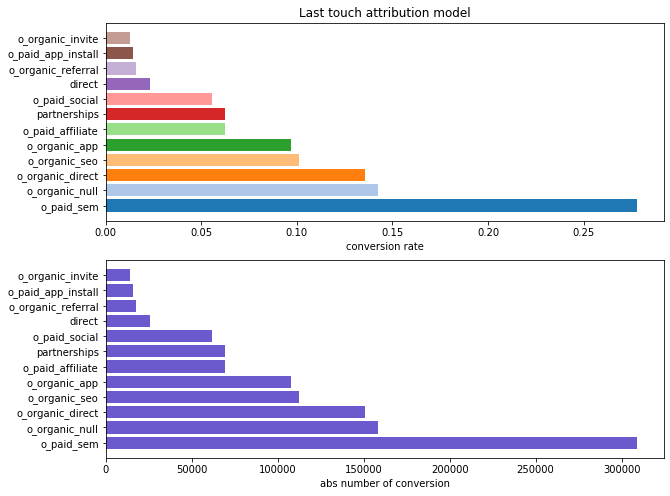

In [171]:
last_touch(basetable)

## 3.2 Monthly Basic

In [174]:
basetable_m = basetable.assign(year_month = basetable.organization_created.dt.to_period('M'))

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [175]:
basetable_m.head()

,organization_uuid,organization_created,country_id,traffic_source_full,traffic_source,year_month
2,80db2bc0-01d1-11e8-ad11-12c187b329b9,2018-01-25 13:13:15.644000+00:00,IT,ds_inbound_inbound,direct,2018-01
4,46024260-d443-11e7-b81c-ba318e3c1c62,2017-11-28 13:51:46.054000+00:00,IT,ds_inbound_inbound,direct,2017-11
12,20bfe2a0-ca20-11e7-aa13-9821d1e27854,2017-11-15 16:14:59.530000+00:00,IT,ds_inbound_inbound,direct,2017-11
18,8d243380-d0fe-11e7-8e34-7d89207b4112,2017-11-24 10:02:16.632000+00:00,IT,ds_inbound_inbound,direct,2017-11
31,98227cb0-1cb7-11e8-91a2-2e18e2ea858c,2018-02-28 18:45:49.179000+00:00,IT,ds_inbound_inbound,direct,2018-02


In [241]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')
    

In [242]:
last_touch_m = last_touch_m(basetable_m)

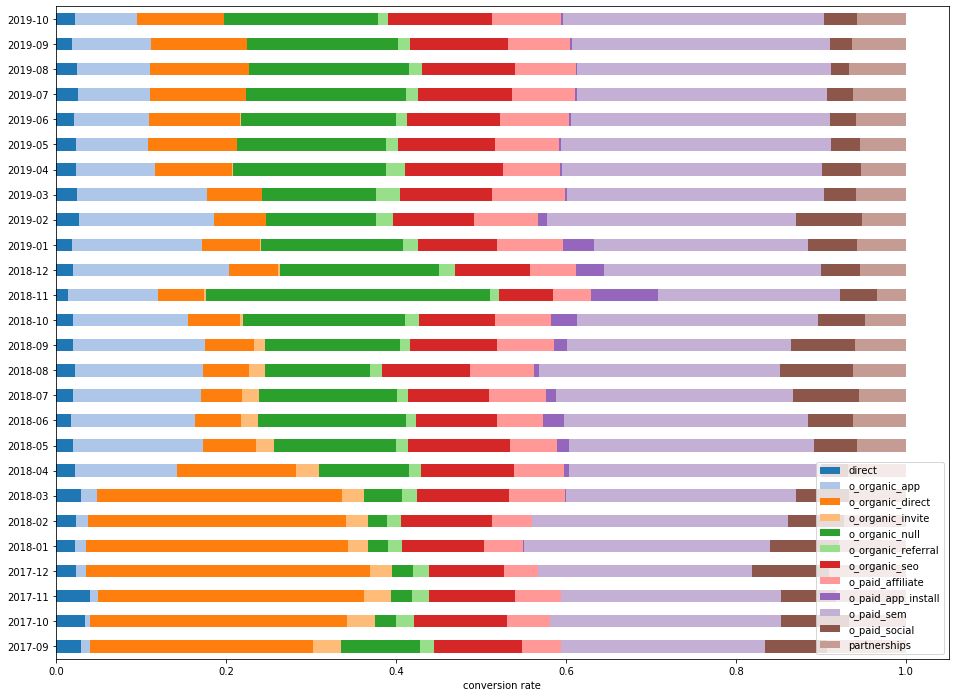

In [180]:
last_touch_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.show()

## 3.3 Markets

In [181]:
country_list = basetable_m.country_id.unique()

In [183]:
country_list_main = ['BR', 'GB', 'FR', 'MX', 'FI', 'NO', 'ES', 'NL', 'DE', 'DK', 'IT', 'SE']

In [185]:
def last_touch_markets(df):
    for i in country_list_main:
        table = df[df['country_id'] == i]
        print(i)
        last_touch(table)

BR


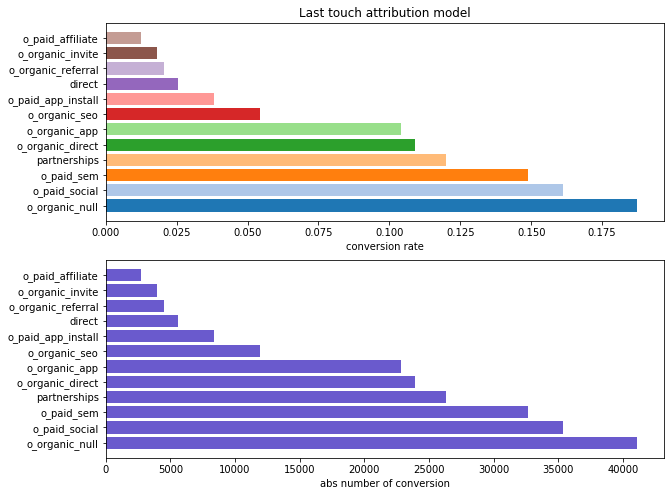

GB


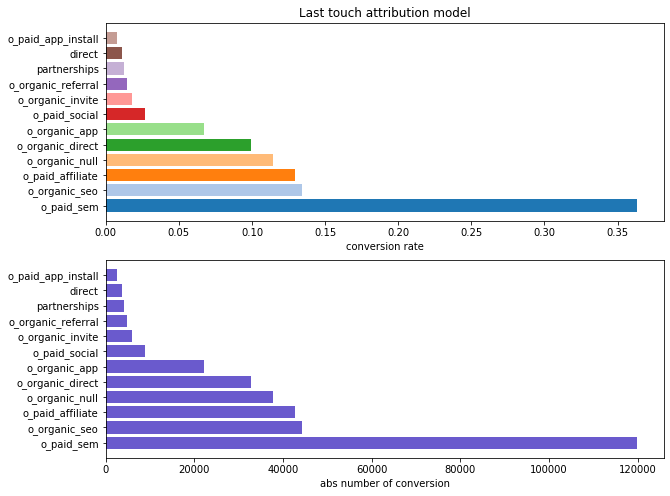

FR


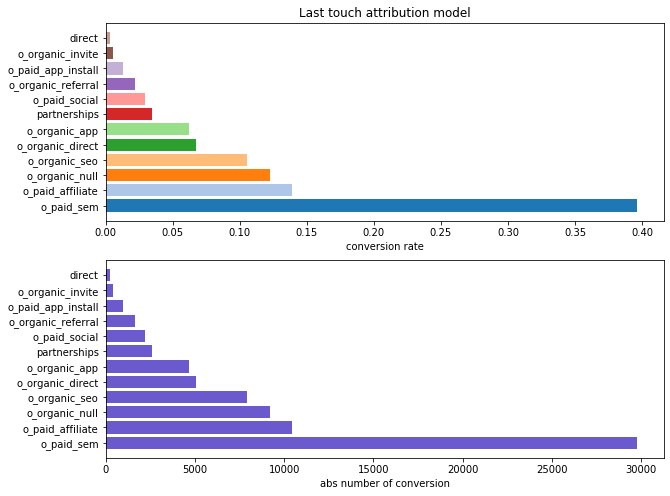

MX


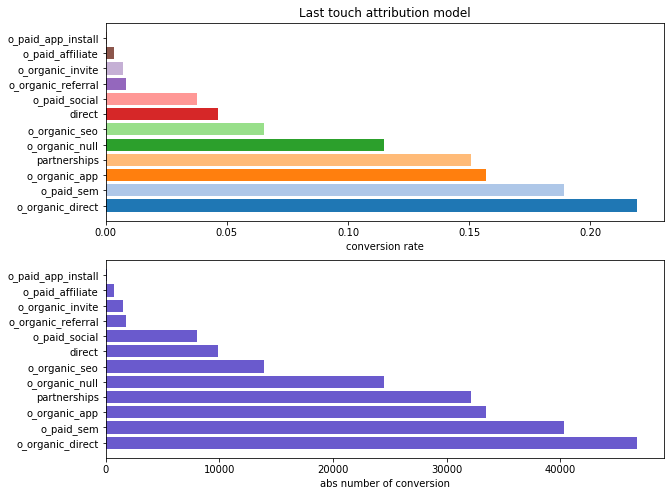

FI


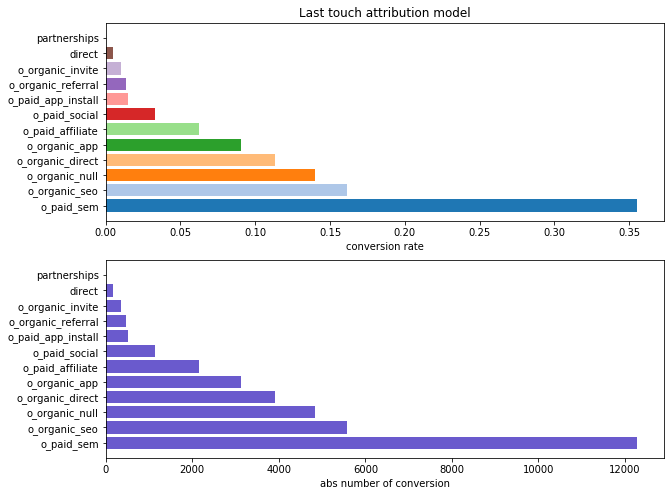

NO


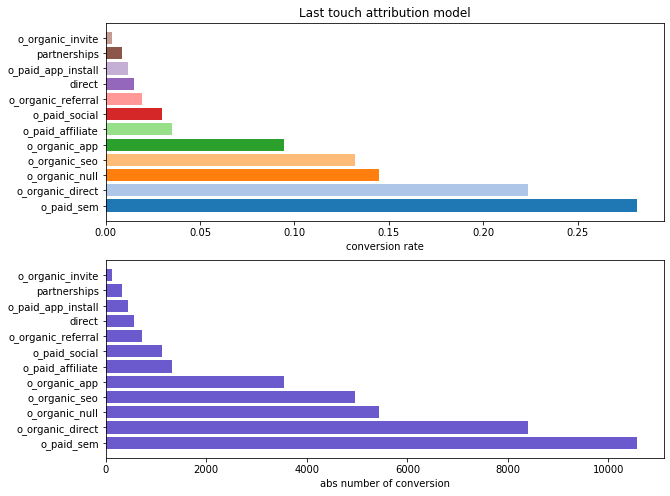

ES


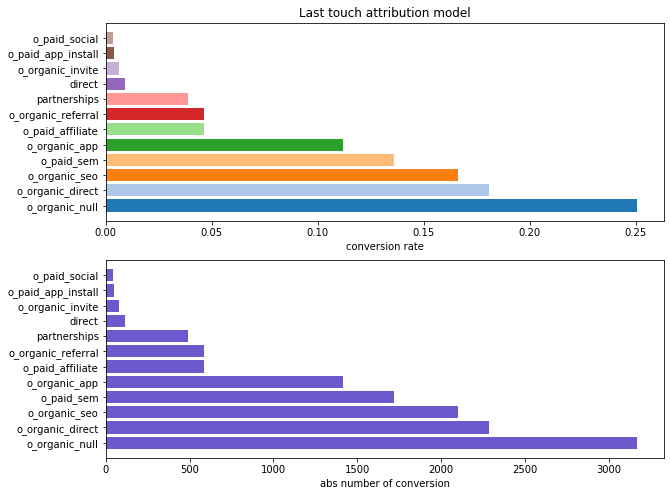

NL


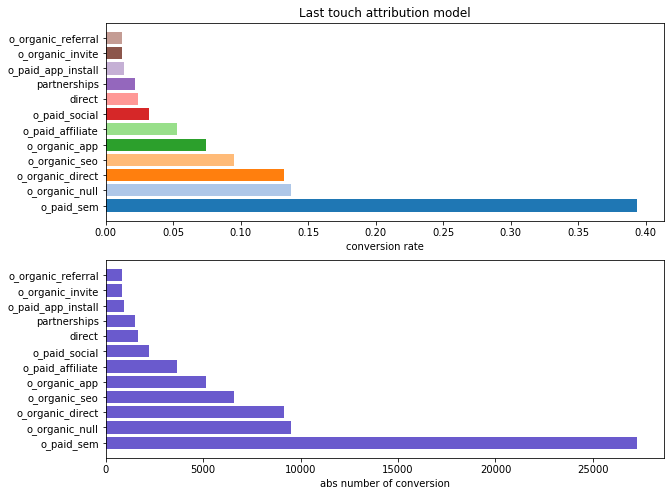

DE


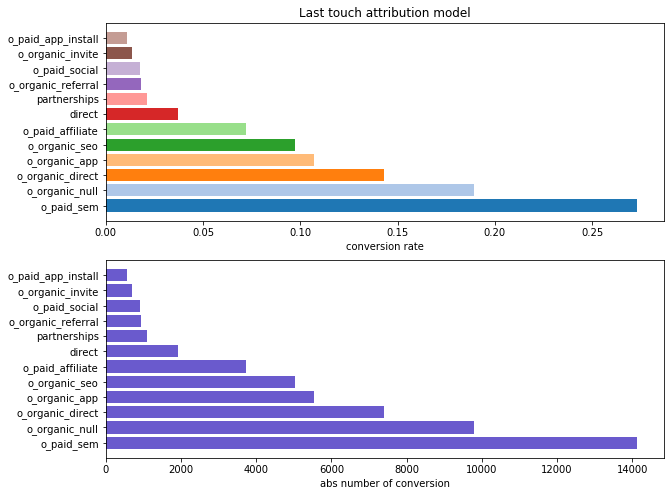

DK


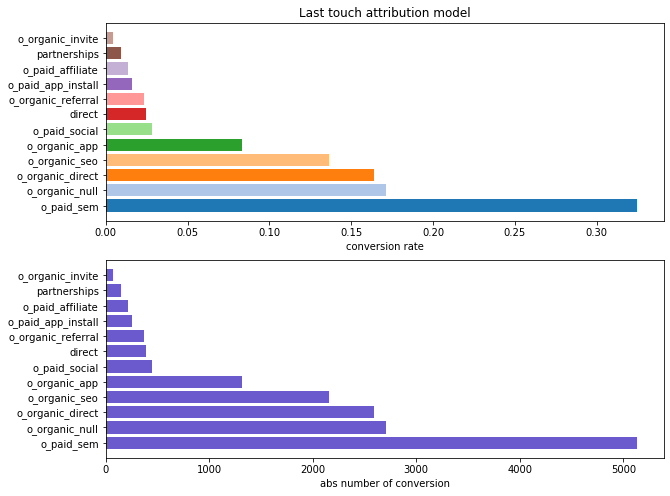

IT


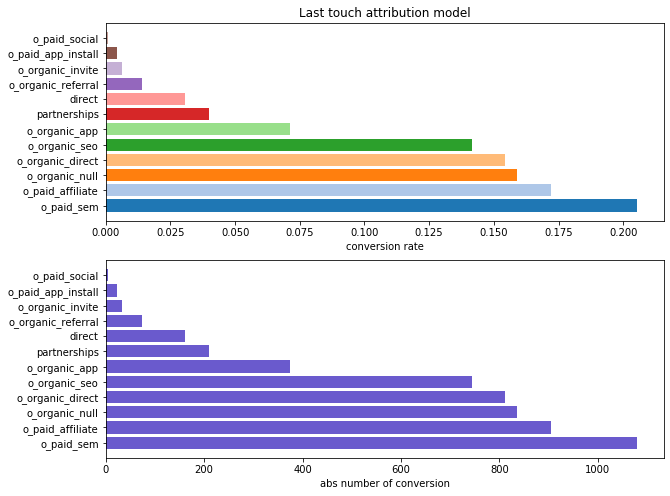

SE


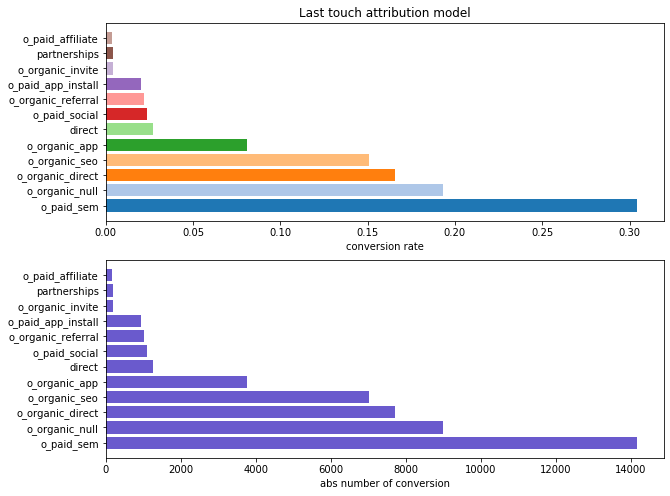

In [186]:
last_touch_markets(basetable_m)

In [211]:
df_af_group_country = pd.DataFrame(df_af.groupby('country_id')['organization_uuid'].count()).reset_index()

In [216]:
df_af_group_country = df_af_group_country[df_af_group_country['organization_uuid'] > 100]
df_af_group_country.rename(columns = {'organization_uuid':'nr_merchants'}, inplace = True)


,country_id,nr_merchants
7,BR,219365
12,DE,51734
13,DK,15814
17,ES,12640
19,FI,34558
20,FR,75154
21,GB,329950
32,IT,5259
43,MX,213180
44,NL,69276


In [220]:
ga_group_country = pd.DataFrame(basetable.groupby('country_id')['organization_uuid'].count()).reset_index()
ga_group_country = ga_group_country[ga_group_country['organization_uuid'] > 100]
ga_group_country.rename(columns = {'organization_uuid':'nr_merchants'}, inplace = True)

In [224]:
correct_merge = df_af_group_country.merge(ga_group_country, how = 'left', on = 'country_id' )
correct_merge.rename(columns = {'nr_merchants_x':'af_nr_merchants', 'nr_merchants_y':'ga_nr_merchants'}, inplace = True)

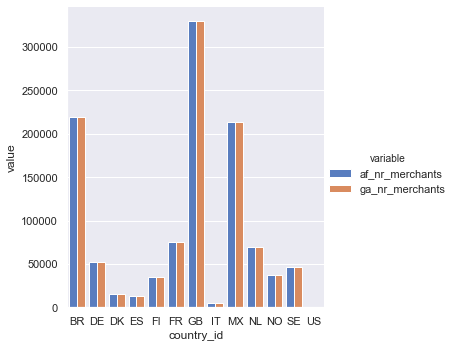

In [227]:
sbn.set(rc={'figure.figsize':(18,16)})
sbn.catplot(x="country_id", y="value", hue="variable", data=correct_merge.melt(id_vars = 'country_id'),
                kind="bar", palette="muted")
plt.show()

## 3.4 Monthly basic and Markets

In [245]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')

In [246]:
def last_touch_markets(df):
    for i in country_list_main:
        table = df[df['country_id'] == i]
        title = i
        
        last_touch = last_touch_m(table)
        
        pal = sbn.color_palette("tab20")
        last_touch.plot.barh(stacked = True,
                         rot = 0, colors = pal,
                         figsize = (14,10))
        plt.xlabel('conversion rate')
        plt.ylabel('')
        plt.xlabel('')
        plt.legend(loc = 'upper right')
        plt.title(title)
        plt.show()

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


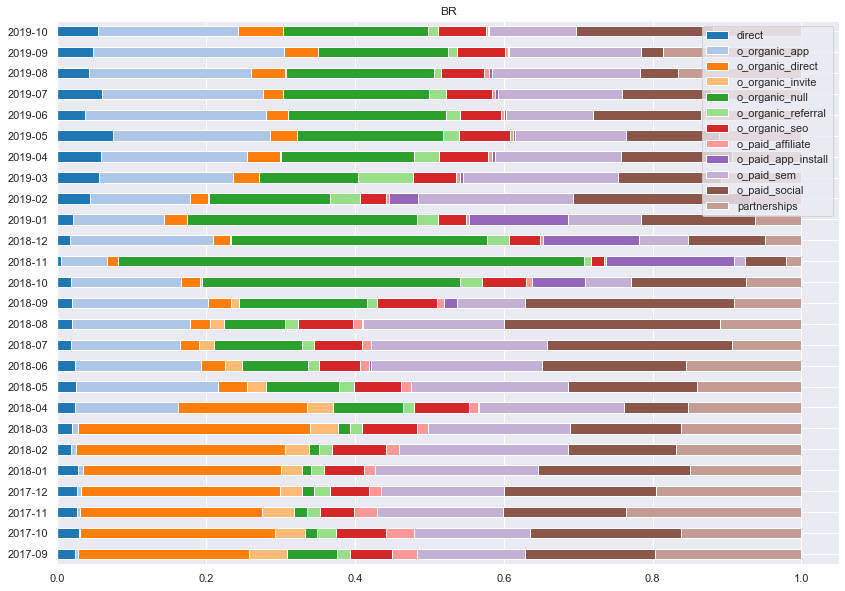

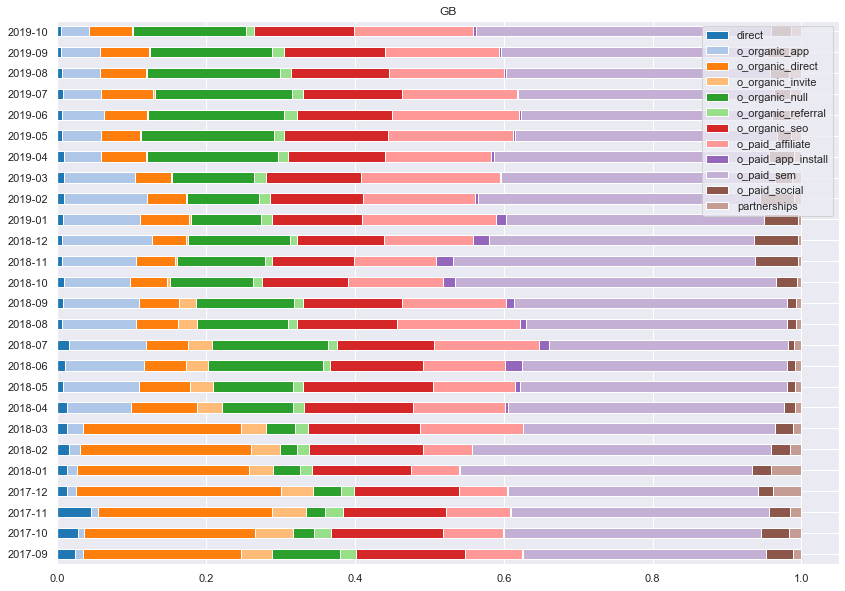

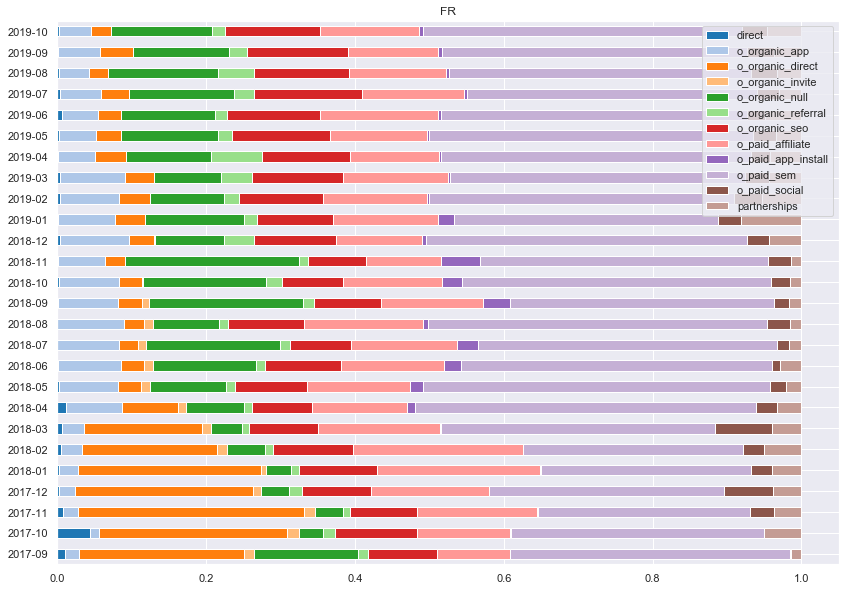

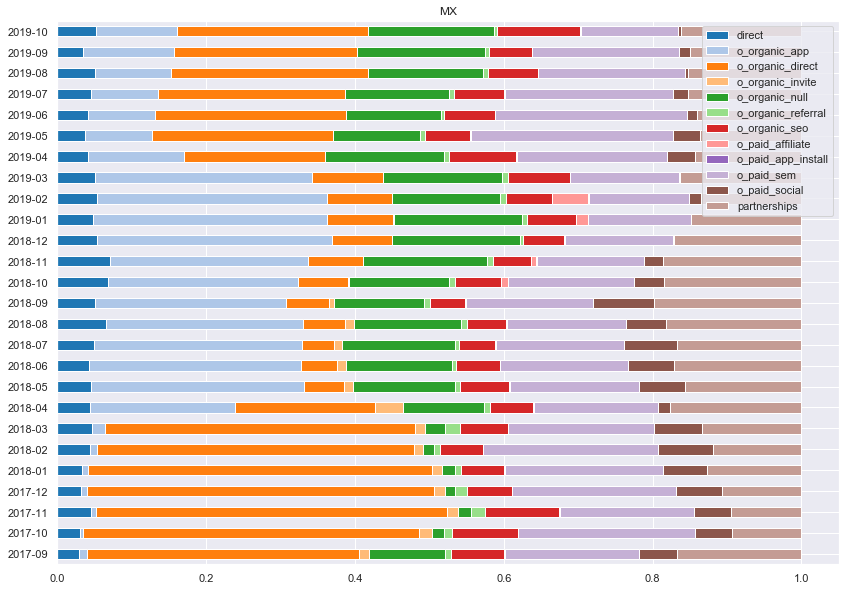

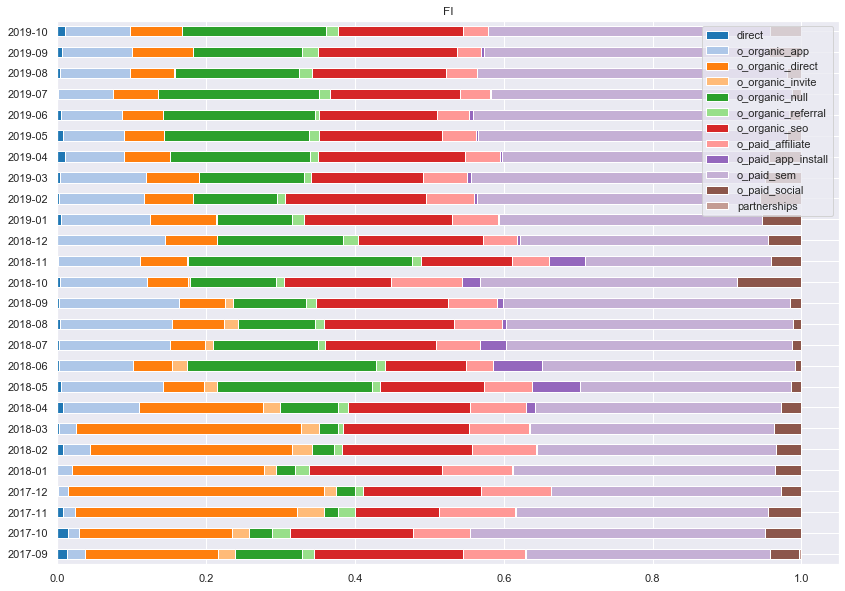

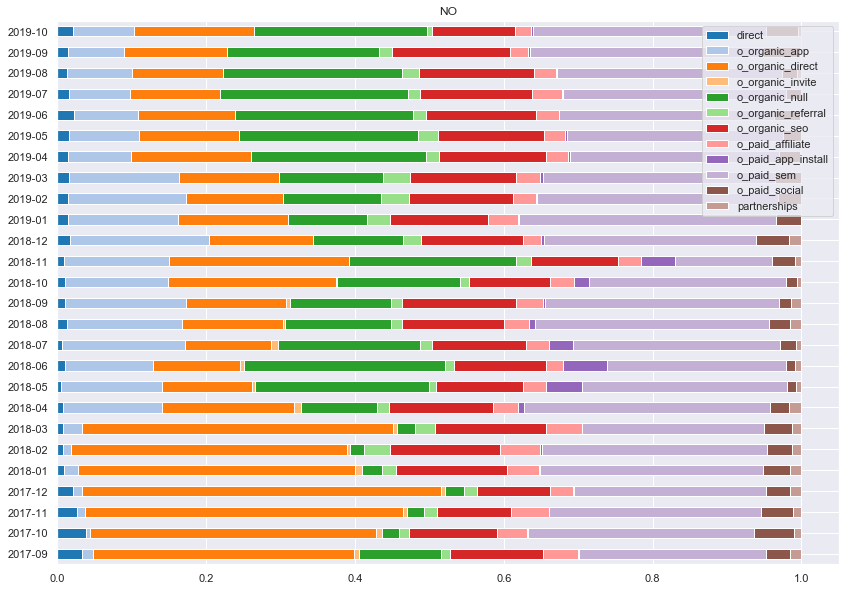

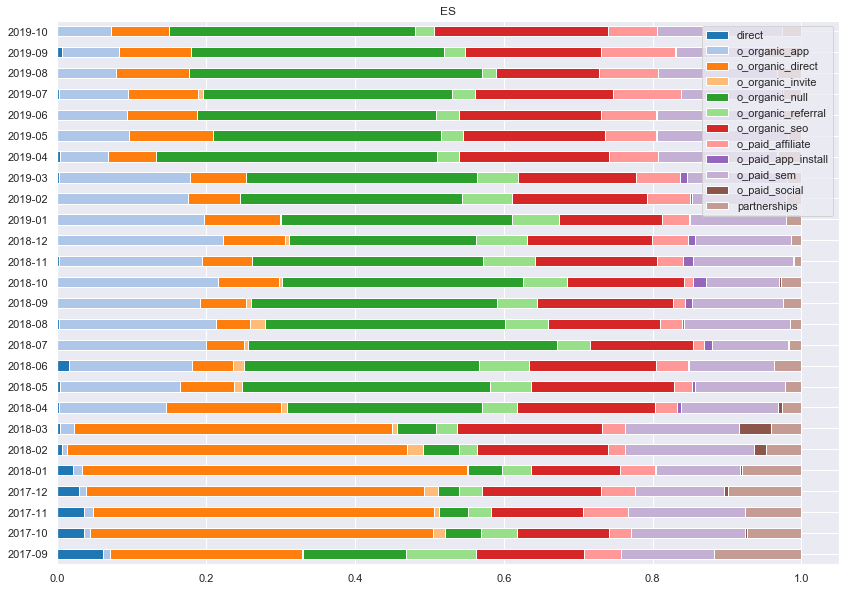

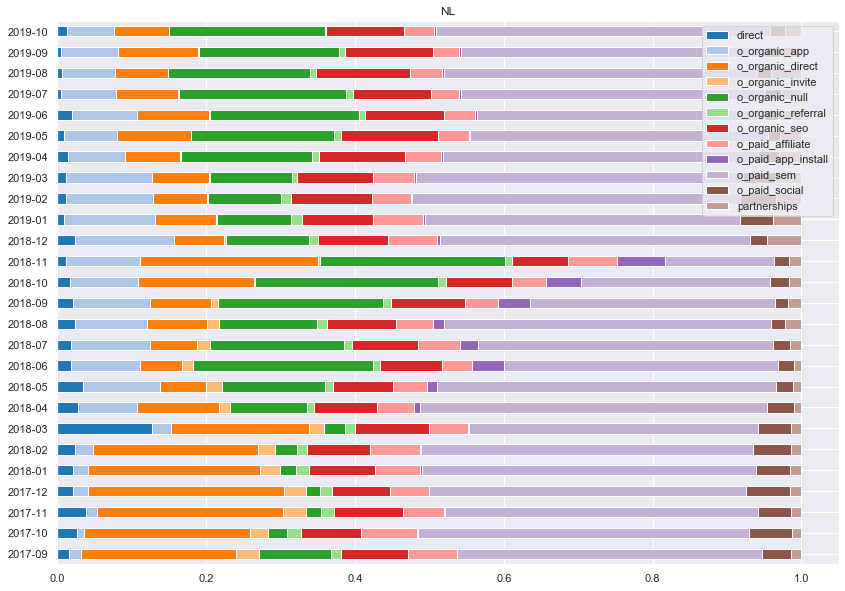

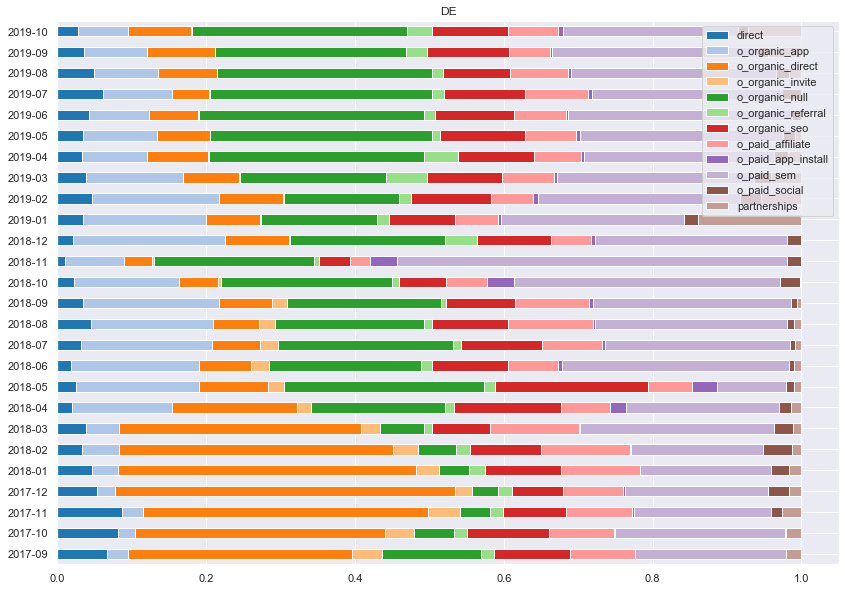

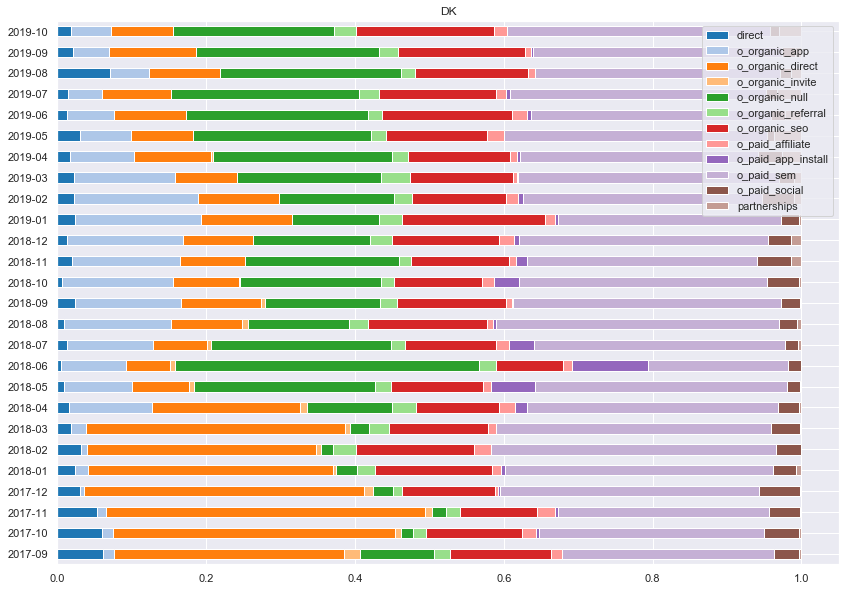

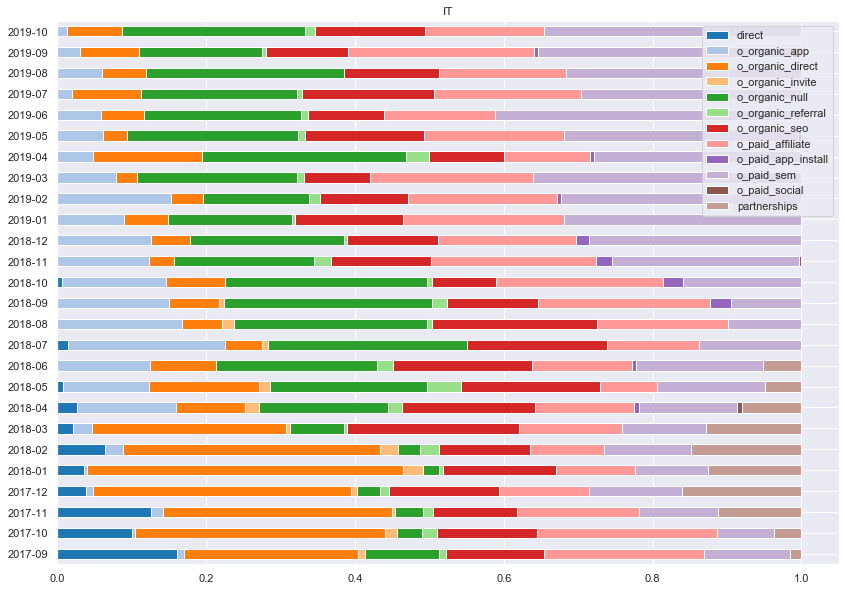

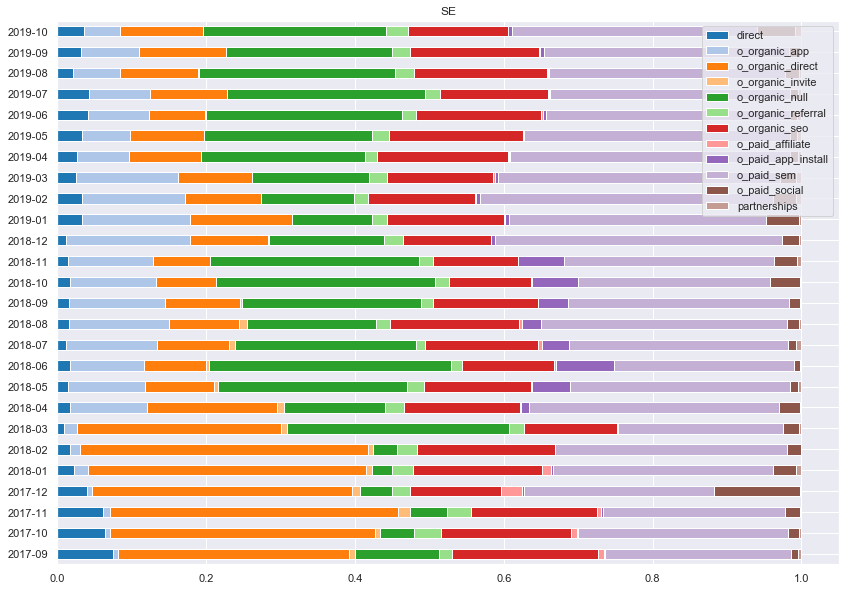

In [247]:
last_touch_markets(basetable_m)